In [986]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error
from random import *

In [987]:
# Variabili globali

path = 'pala_ok/fullDischargeGoodmotor/'

In [988]:
allNI = []
allRPM = []
all_Volts = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]

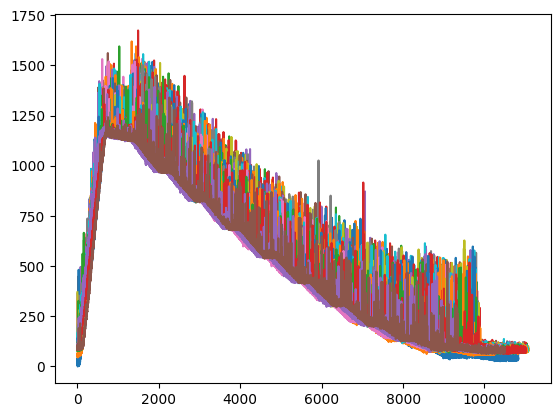

In [989]:
NiPrefix = 'measure_NI'
VoltsPrefix = 'measure_Volts'
RpMPrefix = 'measure_RPM'

for a in range(int(len(path_acquisizioni)/3)):
    allRPM.append(pd.read_csv(path+RpMPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    all_Volts.append(pd.read_csv(path+VoltsPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    try:
        allNI.append(pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    except:
        df = pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True)
        allNI.append(df.rename(columns={"Time": "time"}))

        

allacqui = []
for a,b in zip(allNI,range(len(allNI))):
    allacqui.append([])
    a['Voltage'] = (10 - a['Voltage'])*500
    plt.plot(a['Voltage'])
    allacqui[-1].append(a)

In [990]:
print(len(allNI))
print(len(all_Volts))
print(len(allRPM))

46
46
46


In [991]:
def data_augmentation(df:pd.DataFrame,dimension:int):

    difference = dimension-df.shape[0]
    random_value = np.random.randint(min(df.index.to_list())+1,max(df.index.to_list())-1,difference)
    def sampleValues(index):
        time = df.columns.values[0]
        value = df.columns.values[1]
        new_value = (df.loc[index][value]+df.loc[index+1][value])/2
        new_timestamp = df.loc[index][time] + 1000
        return {time:new_timestamp, value:new_value}

    #new_row = list(map(sampleValues,random_value))
    #newrows = 
    df = pd.concat([df, pd.DataFrame(list(map(sampleValues,random_value)))]).sort_values('time').reset_index(drop=True)

    return df
        


In [992]:
max_list = []

for a in allNI:
    max_list.append(a.shape[0])

print(max(max_list))

for a in allNI[0]['Voltage']:
    print(a)

11077
9.90974968590308
9.90974968590308
27.033333244617097
41.57222494541202
5.548082175664604
16.856109054059765
10.071292927023023
4.094193005585112
6.032711899024434
-1.2367339513730258
13.948330713901669
13.625244231661782
4.740365970064886
5.709625416783659
3.932649764465168
9.10203348030425
6.032711899024434
10.717465891502798
10.232836168142967
4.578822728944942
5.871168657903603
6.194255140144378
7.486601069103926
10.071292927023023
5.38653893454466
7.001971345744096
6.517341622384265
16.533022571820766
10.879009132621853
11.848268579342403
4.255736246705055
8.61740375694442
41.24913846317213
3.4480200411053374
115.39748613722622
29.133395379176363
6.517341622384265
5.709625416783659
4.9019092111848295
10.717465891502798
4.578822728944942
1.8325876299059018
10.232836168142967
55.30340044060722
5.871168657903603
22.99475221661762
9.10203348030425
18.47154146526009
10.717465891502798
11.20209561486174
13.786787472781725
22.025492769898847
13.625244231661782
13.786787472781725
19.

In [993]:
test1 = data_augmentation(allNI[0],11077)
test2 = data_augmentation(allRPM[0],11077)
print(test2.shape)
print(test1.shape)

(11077, 2)
(11077, 2)


In [994]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = test1['Voltage']
grid_points = test2['rpm']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)
    

In [995]:
#get PWN from the RPM data.
from scipy.signal import argrelextrema
def getPWM(DataFrameRPM):
    #Get PWN of RPM/Battery
    DataFrameMean = DataFrameRPM['rpm'].rolling(30,min_periods = 1,center=False).mean()
    gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
    gradientDataframe = pd.DataFrame(gradient)
    ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
    ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
    Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
    def genpwm(x):
        res = 100
        for i in Minindexes:
            if x>i:
                res = res-10
        return res
    ranges = DataFrameRPM.index
    maxindex = gradientDataframe.iloc[ilocs_max].nlargest(1,0, keep='first')
    pwmRPM = list(map(genpwm,list(ranges)))
    pwmRPM[:maxindex.index[0]] = [0] * (maxindex.index[0])
        
    return pwmRPM

c:\Users\Leo\.conda\envs\manu2\lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


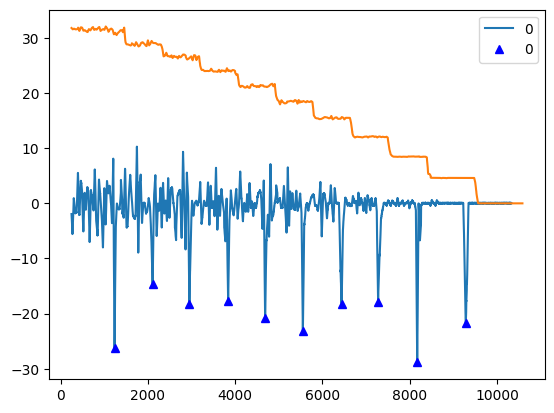

In [996]:

from scipy.signal import argrelextrema
DataFrameMean = allRPM[0]['rpm'][250:].rolling(30,min_periods = 1,center=False).mean()
#allRPM[0]['rpm'].plot()
gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
gradientDataframe = pd.DataFrame(gradient)

rollmax = np.array(pd.DataFrame(gradient).rolling(30,min_periods = 1,center=False).max())[:,0]
rollmaxDataframe = pd.DataFrame(gradient)

ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
fig, ax = plt.subplots(1, 1)
gradientDataframe[250:].plot(ax=ax)
(allRPM[0]['rpm'][250:]/300).plot(ax=ax)
#gradientDataframe.iloc[ilocs_max].plot(style='.', lw=10, color='red', marker="v",ax=ax);
#gradientDataframe.iloc[ilocs_max].plot(style='.', lw=10, color='red', marker="v",ax=ax);
#gradientDataframe.iloc[ilocs_min].plot(style='.', lw=10, color='green', marker="^",ax=ax);
gradientDataframe.iloc[Minindexes].plot(style='.', lw=10, color='blue', marker="^",ax=ax);

<Axes: >

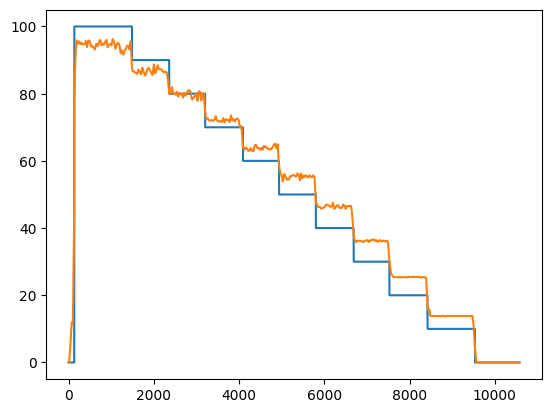

In [997]:
allPWM = [None] * len(allNI)
dim = max([len(allNI[0].index),len(allRPM[0].index),len(all_Volts[0].index)])
#allRPM[0] = data_augmentation(allRPM[0],dim)
allPWM[0] = pd.DataFrame(getPWM(allRPM[0]),columns=['pwm'])
allPWM[0]['pwm'].plot()
(allRPM[0]['rpm']/100).plot()

In [998]:
allPWM = [None] * len(allNI)
pwm_min,pwm_max,pwm_offset = 1000,2000,1000
for ni,rpm,volt,indice in zip(allNI,allRPM,all_Volts,range(len(allNI))):
    dim = max([len(ni.index),len(rpm.index),len(volt.index)])

    allNI[indice] = data_augmentation(ni,dim).rolling(30,min_periods = 1,center=False).median()
    allRPM[indice] = data_augmentation(rpm,dim)
    all_Volts[indice] = data_augmentation(volt,dim)
    allPWM[indice] = pd.DataFrame(getPWM(allRPM[indice]),columns=['pwm'])

    cutIndex = allNI[indice].nlargest(1,'Voltage', keep='first').index[0]
    allPWM[indice] = allPWM[indice].iloc[cutIndex:]*pwm_offset/100+pwm_min
    all_Volts[indice] = all_Volts[indice].iloc[cutIndex:]
    allRPM[indice] = allRPM[indice].iloc[cutIndex:]
    allNI[indice] = allNI[indice].iloc[cutIndex:]

In [999]:
print(allNI[0])
maxindex = allNI[0].nlargest(1,'Voltage', keep='first').index[0]
print(maxindex)

               time      Voltage
695    1.684762e+15  1260.254436
696    1.684762e+15  1259.769806
697    1.684762e+15  1259.769806
698    1.684762e+15  1259.769806
699    1.684762e+15  1259.527491
700    1.684762e+15  1259.446720
701    1.684762e+15  1259.527491
702    1.684762e+15  1259.527491
703    1.684762e+15  1259.850578
704    1.684762e+15  1259.850578
705    1.684762e+15  1259.527491
706    1.684762e+15  1259.446720
707    1.684762e+15  1258.881318
708    1.684762e+15  1258.154374
709    1.684762e+15  1258.881318
710    1.684762e+15  1258.800547
711    1.684762e+15  1258.800547
712    1.684762e+15  1258.800547
713    1.684762e+15  1258.154374
714    1.684762e+15  1258.800547
715    1.684762e+15  1259.365948
716    1.684762e+15  1258.800547
717    1.684762e+15  1259.365948
718    1.684762e+15  1259.527491
719    1.684762e+15  1259.365948
720    1.684762e+15  1259.365948
721    1.684762e+15  1259.365948
722    1.684762e+15  1258.800547
723    1.684762e+15  1258.800547
724    1.6

<Axes: >

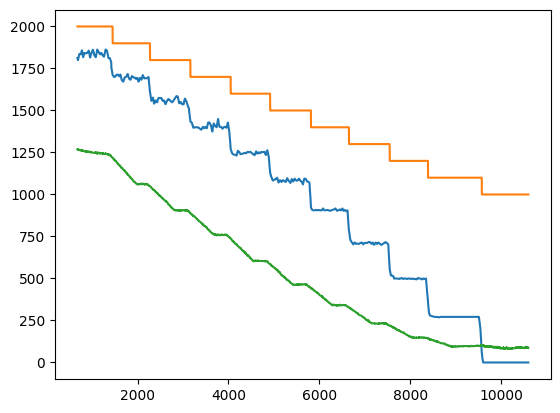

In [1000]:
for a in range(len(allPWM)):
    allPWM[a].replace(to_replace=np.NaN, value=0,inplace = True)

for a in range(len(allRPM)):
    allRPM[a]['pwm'] = allPWM[a]

p = 10
(allRPM[p]['rpm']/5).plot()
allRPM[p]['pwm'].plot()
(allNI[p]['Voltage']).plot()

In [1001]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []
all_data_grid_pwm = []
for ni,rpm,pwm in zip(allNI,allRPM,allPWM):
        
    data_matrix = np.flip(np.array(ni[ni.columns.values[1]]))
    grid_points = np.flip(np.array(rpm[rpm.columns.values[1]]))

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name='pippo',
    argument_names=(rpm.columns.values[1],),
    coordinate_names=(ni.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

    all_data_grid_pwm.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points = np.flip(np.array(pwm[pwm.columns.values[0]])),
    dataset_name='pippo',
    argument_names=(pwm.columns.values[0],),
    coordinate_names=(ni.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

c:\Users\Leo\.conda\envs\manu2\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


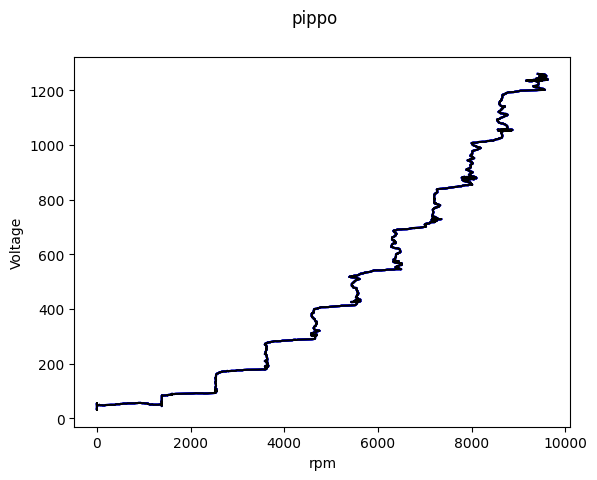

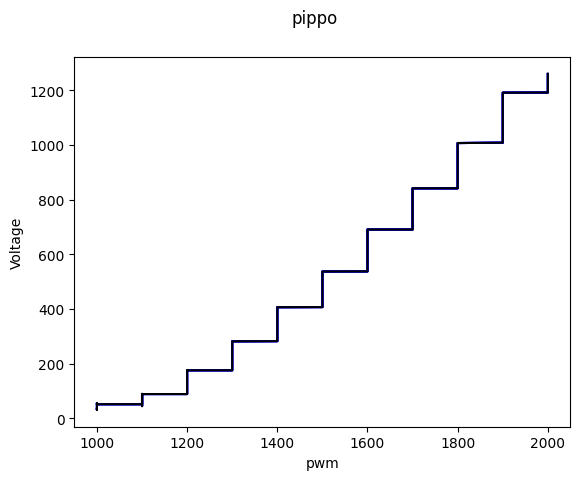

In [1002]:
fdBoxplot = Boxplot(all_data_grid[0])
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print()

fdBoxplot1 = Boxplot(all_data_grid_pwm[0])
fdBoxplot1.show_full_outliers = True
fdBoxplot1.plot()
print()

In [1003]:
print(all_data_grid[0].grid_points)

(array([   0.,    0.,    0., ..., 9421., 9418., 9414.]),)


In [1004]:
#Fitting for National Instrument
pol_maxGrade = 4
fit_result = []
fit_result_pwm = []
for i in range(pol_maxGrade):
    fit_result.append([])
    fit_result_pwm.append([])
    for j in range(len(all_data_grid)):
        fit_result[-1].append(polyfit(all_data_grid[j].grid_points[0],all_data_grid[j].data_matrix[0],deg=i+1))
        fit_result_pwm[-1].append(polyfit(all_data_grid_pwm[j].grid_points[0],all_data_grid_pwm[j].data_matrix[0],deg=i+1))



In [1005]:
def makeColor(start:tuple = (1,0,0),end:tuple = (0,0,1),step:int = 46):
    if len(start)!=3 or len(end)!=3:
        raise Exception("not valid color")
    res = [None] * step
    for i in range(step):
        res[i] = (start[0]+(end[0] - start[0])*i/step,start[1]+(end[1] - start[1])*i/step,start[2]+(end[2] - start[2])*i/step,0.5)
    return res

2
[-144.20841616]
[0.12960853]
2
[-121.45757486]
[0.13217258]
2
[-96.73168392]
[0.13215924]
2
[-93.5611953]
[0.13259675]
2
[-94.35426821]
[0.13294713]
2
[-75.13184478]
[0.131817]
2
[-84.35688722]
[0.13031633]
2
[-89.71335918]
[0.13138457]
2
[-87.72960996]
[0.13056708]
2
[-92.5684711]
[0.12939389]
2
[-91.31046943]
[0.12975611]
2
[-91.66590613]
[0.12941532]
2
[-92.97786775]
[0.12636299]
2
[-91.58908345]
[0.13008395]
2
[-89.03550745]
[0.12849688]
2
[-83.29979586]
[0.13148693]
2
[-95.12592687]
[0.12617143]
2
[-92.11978551]
[0.12723914]
2
[-87.40498762]
[0.12802502]
2
[-86.32725871]
[0.12623598]
2
[-87.56928222]
[0.12872412]
2
[-85.35123591]
[0.12828015]
2
[-86.90530447]
[0.12712537]
2
[-90.62440826]
[0.12775562]
2
[-89.05865477]
[0.12703585]
2
[-89.58939983]
[0.12737791]
2
[-89.49277885]
[0.12633941]
2
[-90.76491387]
[0.12804354]
2
[-91.49359167]
[0.12602247]
2
[-88.0050541]
[0.12724174]
2
[-84.52147385]
[0.12570423]
2
[-83.7878545]
[0.12669848]
2
[-83.91785719]
[0.12625709]
2
[-83.5075563

"for fit in fit_result[0][0]:\n    print(len(fit))\n    plotRes = np.array([0]*(max_rpm-min_rpm),dtype='longdouble')\n    for i in range(len(fit)):\n        print(fit[i])\n        plotRes += np.multiply(fit[i],np.power(linex,i))\n    axs[0].plot(linex, plotRes,'-')"

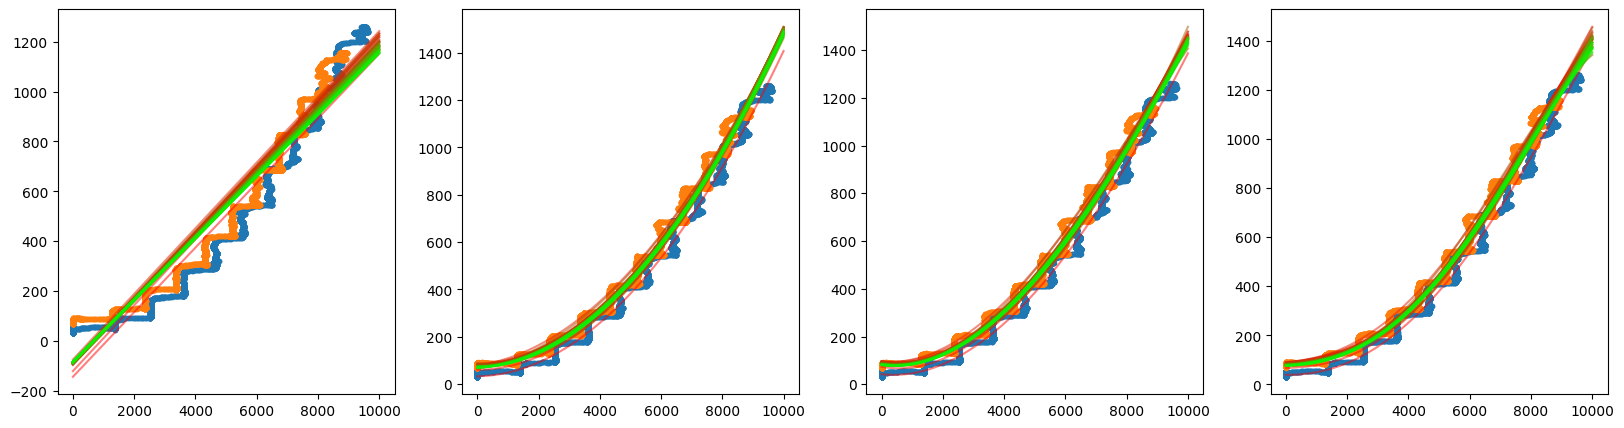

In [1006]:
fig, axs = plt.subplots(nrows = 1, ncols = pol_maxGrade)
fig.set_size_inches(h=5,w=20)
min_rpm,max_rpm = 0,10000
colors = makeColor((1,0,0),(0,1,0))
linex = np.arange(min_rpm,max_rpm,1,dtype='longdouble')


for grade_fit,grade in zip(fit_result,range(pol_maxGrade)):
        axs[grade].plot(all_data_grid[0].grid_points[0],all_data_grid[0].data_matrix[0],'.')
        axs[grade].plot(all_data_grid[len(all_data_grid)-1].grid_points[0],all_data_grid[len(all_data_grid)-1].data_matrix[0],'.')
        for fit,index in zip(grade_fit,range(len(grade_fit))):
                plotRes = np.array([0]*(max_rpm-min_rpm),dtype='longdouble')
                print(len(fit))
                for i in range(len(fit)):
                        print(fit[i])
                        plotRes += np.multiply(fit[i],np.power(linex,i))
                axs[grade].plot(linex, plotRes,'-',color=colors[index])



2
[-1327.14549574]
[1.23840433]
2
[-1323.16894405]
[1.25861318]
2
[-1294.72948845]
[1.25448851]
2
[-1288.56766479]
[1.25237042]
2
[-1283.47194152]
[1.24860784]
2
[-1246.36552163]
[1.23069554]
2
[-1248.73925904]
[1.22135693]
2
[-1180.79934594]
[1.16325633]
2
[-1257.89171437]
[1.22517401]
2
[-1335.47887811]
[1.28339536]
2
[-1245.81639296]
[1.20971383]
2
[-1238.37354372]
[1.2025601]
2
[-1220.44807504]
[1.17907748]
2
[-1241.05563515]
[1.20572265]
2
[-1225.49298842]
[1.1909177]
2
[-1241.50778949]
[1.2143961]
2
[-1215.55379563]
[1.17128397]
2
[-1167.98378841]
[1.1380659]
2
[-1208.87220633]
[1.17537571]
2
[-1195.41370243]
[1.16126682]
2
[-1160.48356525]
[1.13201332]
2
[-1208.06813925]
[1.17620965]
2
[-1194.76828012]
[1.16120949]
2
[-1200.43449696]
[1.16472582]
2
[-1161.9421448]
[1.13168288]
2
[-1200.84627897]
[1.16360041]
2
[-1189.93865567]
[1.15191095]
2
[-1202.49521439]
[1.16507336]
2
[-1184.33839125]
[1.14413575]
2
[-1119.34270018]
[1.09431052]
2
[-1190.63751073]
[1.15550155]
2
[-1169.2108

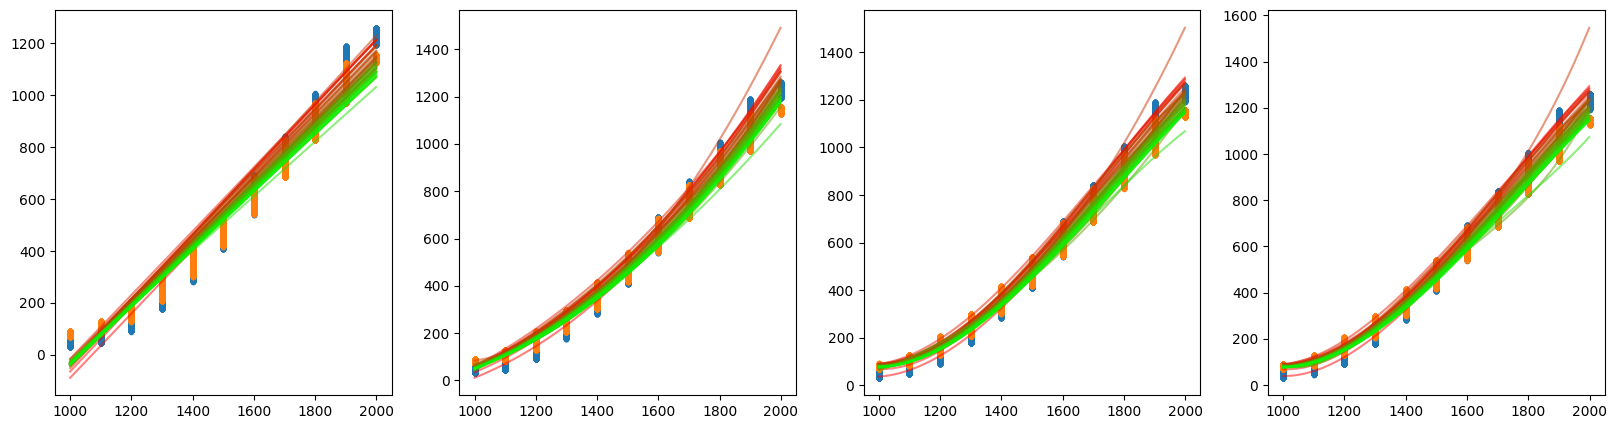

In [1011]:
fig, axs = plt.subplots(nrows = 1, ncols = pol_maxGrade)
fig.set_size_inches(h=5,w=20)
pwm_min,pwm_max = 1000,2000
colors = makeColor((1,0,0),(0,1,0))
linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')


for grade_fit,grade in zip(fit_result_pwm,range(pol_maxGrade)):
        axs[grade].plot(all_data_grid_pwm[0].grid_points[0],all_data_grid_pwm[0].data_matrix[0],'.')
        axs[grade].plot(all_data_grid_pwm[len(all_data_grid_pwm)-1].grid_points[0],all_data_grid_pwm[len(all_data_grid_pwm)-1].data_matrix[0],'.')
        for fit,index in zip(grade_fit,range(len(grade_fit))):
                plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
                print(len(fit))
                for i in range(len(fit)):
                        print(fit[i])
                        plotRes += np.multiply(fit[i],np.power(linex,i))
                axs[grade].plot(linex, plotRes,'-',color=colors[index])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


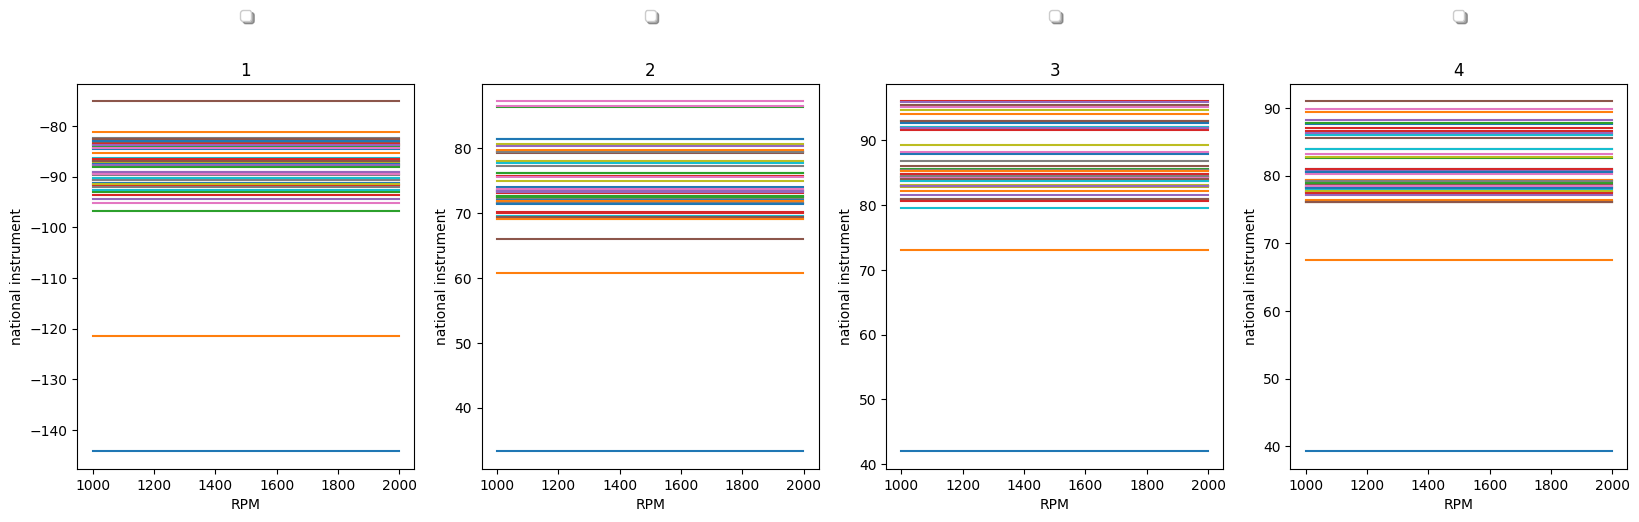

In [1008]:
datasetTitles = ['National Instrument','RPM','Battery']
fig, axs = plt.subplots(nrows = 1, ncols = pol_maxGrade)
fig.set_size_inches(h=5,w=20)
for fit_poly,index in zip(fit_result,range(len(fit_result))):
    axs[index].set_xlabel('RPM')
    axs[index].set_ylabel('national instrument')
    linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
    
    for fit,acqui in zip(fit_poly,range(len(fit_poly))):
        #axs[index].plot(dataset.data_matrix[1][:,0],dataset.data_matrix[0],'.')
        
        plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
        for i in range(len(fit[0])):
            plotRes += np.multiply(fit[0][i],np.power(linex,i))
        axs[index].plot(linex, plotRes,'-')
    axs[index].set_title(str(index+1))
    axs[index].legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=4, fancybox=True, shadow=True)

In [1009]:
# Andiamo a calcolare il mean squared error
grafico = 0
y_pred = all_data_grid[grafico][0].data_matrix[0]
for fit,g in zip(fit_result[grafico][0],range(len(fit_result[1][0]))):
    y_true = 0
    for i in range(len(fit)):
        y_true += fit[i]*all_data_grid[grafico][0].data_matrix[1][:,0]**i
    print('grado' + str(g+1))
    print(mean_squared_error(y_true, y_pred[:,0]))

IndexError: index 1 is out of bounds for axis 0 with size 1